# NYC Taxi Fare & Duration
## Exploratory Data Analysis (EDA)

In [1]:
%load_ext autoreload
%autoreload 2

Imports

In [21]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wget

sys.path.append("..")
import source.configs as configs

# Check if we are in COLAB
IN_COLAB = 'google.colab' in sys.modules

In [22]:
if not os.path.exists("../dataset/yellow_tripdata_2022-05.parquet"):
    if IN_COLAB:
        !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet "../dataset"
    else:
        wget.download(configs.START_DATASET_URL, "../dataset")

## Read Dataset

In [23]:
dataset = pd.read_parquet("../dataset/yellow_tripdata_2022-05.parquet")

### List of columns

In [24]:
dataset.columns.to_list()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

### Types of columns

In [25]:
dataset.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

Conclusions
* We have tpep_pickup_datetime, tpep_dropoff_datetime to calculate trip duration.


### Head / Describe

In [26]:
dataset.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.0,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.6,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0


### Relevant features
* trip_distance is a very important feature to predict duration of the trip.
* Trip duration is no in the dataset, but is a target feature we must build using pick-up and drop-off timestamps.
* fare_amount is one of the target variables.
* passenger_count could be relevant.
* PULocationID, DOLocationID, these describe taxi zones, they can relevant.
* RateCodeID: Tells which rate was applied at the end of the trip. It can be relevant.
* The fare amout only depends on duration/distance of the trip. There are other charges that go into total amount.

Check this web page:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Total amount = Fare + Overnight_Charges + RushHour_Charges + ...

In [27]:
dataset.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3.588295e+06,3588295,3588295,3.458771e+06,3.588295e+06,3.458771e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.588295e+06,3.458771e+06,3.458771e+06
mean,1.713103e+00,2022-05-16 07:50:29.219312,2022-05-16 08:08:42.275203,1.393923e+00,6.856861e+00,1.365674e+00,1.645738e+02,1.625517e+02,1.183209e+00,1.516813e+01,1.020728e+00,4.891096e-01,2.824744e+00,5.827756e-01,2.964299e-01,2.207840e+01,2.282808e+00,1.008364e-01
min,1.000000e+00,2003-01-01 00:06:06,2003-01-01 00:31:38,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.311500e+03,-4.500000e+00,-5.000000e-01,-1.457000e+02,-5.075000e+01,-3.000000e-01,-1.314800e+03,-2.500000e+00,-1.250000e+00
25%,1.000000e+00,2022-05-08 18:14:16.500000,2022-05-08 18:32:36,1.000000e+00,1.150000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.235000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2022-05-16 09:14:42,2022-05-16 09:33:15,1.000000e+00,1.960000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.050000e+01,5.000000e-01,5.000000e-01,2.160000e+00,0.000000e+00,3.000000e-01,1.630000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2022-05-23 18:03:17,2022-05-23 18:21:03.500000,1.000000e+00,3.730000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.700000e+01,2.500000e+00,5.000000e-01,3.460000e+00,0.000000e+00,3.000000e-01,2.376000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2022-06-01 23:55:30,2022-06-02 00:03:51,9.000000e+00,3.571927e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,6.966500e+03,8.800000e+00,3.300000e+00,6.650000e+02,8.137500e+02,3.000000e-01,6.970800e+03,2.750000e+00,1.250000e+00
std,4.888093e-01,NaN,NaN,9.555489e-01,6.908488e+02,5.239789e+00,6.562813e+01,7.027926e+01,5.075988e-01,1.489484e+01,1.256724e+00,9.008878e-02,3.368739e+00,2.173699e+00,4.576907e-02,1.848683e+01,7.452415e-01,3.434480e-01


In [28]:
for col in ["VendorID", "RatecodeID", "PULocationID", "DOLocationID",  "payment_type", "passenger_count", "extra", "mta_tax"]:
    print(f"{col}: {dataset[col].nunique()}")

VendorID: 4
RatecodeID: 7
PULocationID: 259
DOLocationID: 261
payment_type: 5
passenger_count: 10
extra: 61
mta_tax: 13


### Trip duration feature

https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

In [58]:
dataset["trip_duration"] = (dataset["tpep_dropoff_datetime"]-dataset["tpep_pickup_datetime"]).dt.total_seconds()/60

### Percentiles

In [59]:
for p in [0.9, 0.95, 0.99, 0.995]:
    print(f"** Percentiles for {p} **")
    for col in ["trip_distance", "fare_amount", "total_amount", "trip_duration"]:
        print(f"  {col} {dataset[col].quantile(p)}")

** Percentiles for 0.9 **
  trip_distance 9.4
  fare_amount 32.5
  total_amount 45.15
  trip_duration 32.45
** Percentiles for 0.95 **
  trip_distance 16.0
  fare_amount 52.0
  total_amount 63.41
  trip_duration 43.95
** Percentiles for 0.99 **
  trip_distance 20.3
  fare_amount 63.0
  total_amount 81.36
  trip_duration 71.45
** Percentiles for 0.995 **
  trip_distance 21.78
  fare_amount 71.5
  total_amount 93.95
  trip_duration 83.06666666666666


### Histogram of trip duration

(array([319123., 810821., 756829., 551061., 367494., 235623., 152674.,
        100131.,  68618.,  50182.,  38002.,  29364.,  23161.,  21618.,
         14431.,  11263.,   8592.,   6580.]),
 array([ 0.        ,  4.44444444,  8.88888889, 13.33333333, 17.77777778,
        22.22222222, 26.66666667, 31.11111111, 35.55555556, 40.        ,
        44.44444444, 48.88888889, 53.33333333, 57.77777778, 62.22222222,
        66.66666667, 71.11111111, 75.55555556, 80.        ]),
 <BarContainer object of 18 artists>)

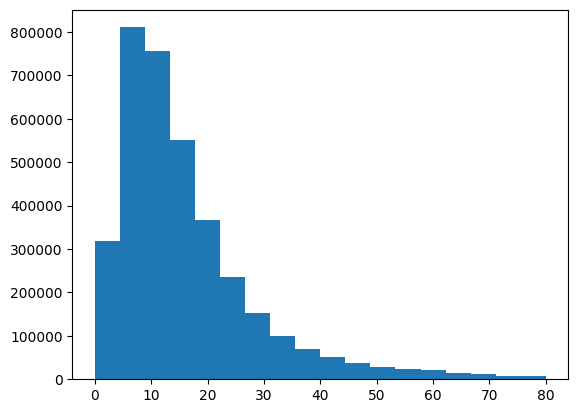

In [64]:
plt.hist(dataset["trip_duration"], bins=18, range=(0,80))

### Histogram of trip distance

(array([1022119., 1161187.,  511221.,  224138.,  126894.,   79732.,
          66708.,   71184.,   59066.,   35991.,   19502.,   15421.,
          20746.,   43257.,   59589.,   30696.,   18007.,    9139.,
           3468.,    1808.]),
 array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
        11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
        22.5 , 23.75, 25.  ]),
 <BarContainer object of 20 artists>)

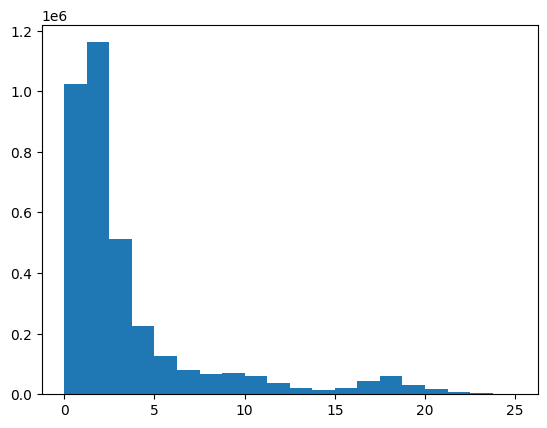

In [30]:
plt.hist(dataset["trip_distance"], bins=20, range=(0,25))

### Histogram of day of week

(array([511026., 598700., 500750., 514870., 492400., 466997., 503552.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

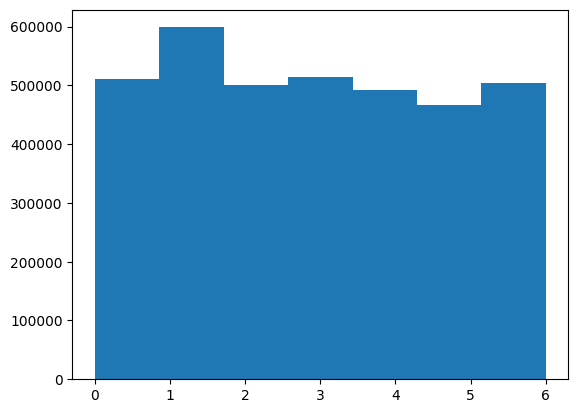

In [31]:
#for col in ["", "tpep_dropoff_datetime", "passenger_count", "",  "payment_type", "PULocationID"]:
plt.hist(dataset["tpep_pickup_datetime"].dt.day_of_week,bins=7)

### Histogram of hour of day

(array([101898.,  65741.,  42649.,  27727.,  19738.,  24285.,  58703.,
        106019., 135426., 152979., 170337., 188606., 201967., 203613.,
        217339., 221873., 220953., 237924., 253314., 230980., 196474.,
        190822., 175247., 143681.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

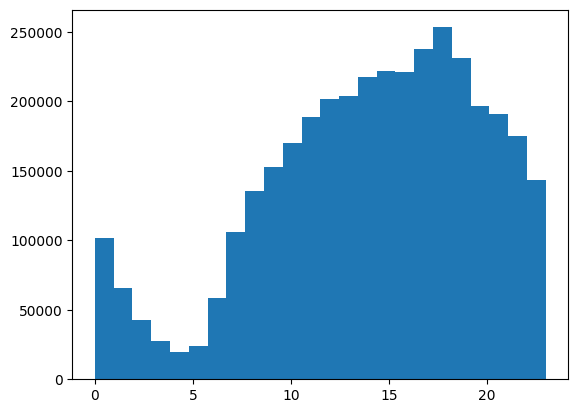

In [32]:
plt.hist(dataset["tpep_pickup_datetime"].dt.hour, bins=24)

### Histogram of fare amount

(array([ 595497., 1603320.,  623481.,  246266.,  138172.,   88364.,
          45510.,   22404.,  160508.,   15003.]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

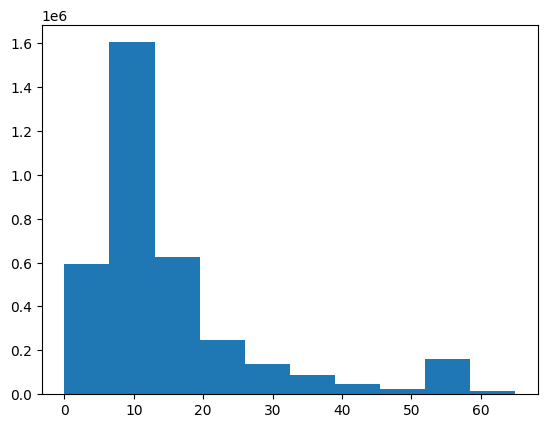

In [20]:
plt.hist(dataset["fare_amount"], bins=10, range=(0,65))